In [1]:
# ===== notes =====
# - 하려는 것
#     - test claim의 corresponding embedding, topic label, is_correct 가지고 토픽별 test accuracy 측정
# - 필요한 데이터
#     - test claim embedding
#     - test claim topic label
#     - test claim True_False
#     - test claim is_correct
# - 모델: tuned_kobert에 labels 추가해서 쓸거임
# cmd: python ./test_accuracy_by_topic.py --visualize --ss_pipeline 1

# import modules
from email.policy import default
import os
import json
import argparse
from collections import defaultdict
import random
import pickle
from tqdm import tqdm, tqdm_notebook
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from sklearn.model_selection import train_test_split

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from new_ss.tuned_kobert import BERTDataset, GetEmbeddings, BERTClassifier, BuildTrainModel

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

/home/yewon/anaconda3/envs/factcheck-ko-2021/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cached model. /home/yewon/factcheck_automization/.cache/kobert_v1.zip
using cached model. /home/yewon/factcheck_automization/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [196]:
class load_files:
  def __init__(self, path, shuffle):
    self._labels = ['정치', '경제', '사회', '생활/문화', '세계', '기술/IT', '연예', '스포츠'] 
    self.data = []
    self.target = []
    for i in tqdm(range(len(self._labels)), desc = 'outer', position = 0):
      for k in tqdm(range(200), desc = 'inner', position = 1, leave = False):
        k = str(k)
        if len(k) == 1:
          file_name = str(i)+'00'+k+'NewsData.txt'
        elif len(k) == 2:
          file_name = str(i)+'0'+k+'NewsData.txt'
        else:
          file_name = str(i)+k+'NewsData.txt'

        with open(os.path.join(path,f'{i}/{file_name}'), 'r') as file:
          content = file.read()
          self.data.append(content)
          self.target.append(i)
        #print(f'{k} is working')
      #print(f'***{i}th is done here')
    
    if shuffle == True:
      self._zipped_lists = list(zip(self.data, self.target))
      random.shuffle(self._zipped_lists)
      self.data, self.target = zip(*self._zipped_lists)
      self.data = list(self.data)
      self.target = list(self.target) 

def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

def testModel(args, seq):
    cate = ["정치","경제","사회", "생활/문화","세계","기술/IT", "연예", "스포츠"]
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(args.tok, args.max_len, pad=True, pair=False)
    tokenized = transform(tmp)
    model = args.model
    #print(f'tokenized: {tokenized}')

    model.eval()
    with torch.no_grad():
        testModel_result = model(torch.LongTensor([tokenized[0]]).to(args.device), [tokenized[1]], torch.LongTensor(tokenized[2]).to(args.device))
        idx = testModel_result.argmax().cpu().item()
    #print("클레임 카테고리는:", cate[idx])
    #print("신뢰도는:", "{:.2f}%".format(softmax(testModel_result,idx)))
    return (idx, model.extracter.embeddings)
        

def getdataset_claim(args):
    # load data
    if os.path.exists('/home/yewon/factcheck_automization/dataset.pickle'):
      with open('/home/yewon/factcheck_automization/dataset.pickle', 'rb') as f:
        dataset = pickle.load(f)
      return dataset

    else:
      with open('/home/yewon/factcheck_automization/data/wiki_claims.json', 'r') as f:
          wiki_claims = json.load(f)
          dataset = defaultdict(dict)
          dataset['claim'] = []
          dataset['True_False'] = []
          dataset['top'] = []
          dataset['emb'] = []
          dataset['pre'] = []
          
      with open('/home/yewon/factcheck_automization/data/train_val_test_ids.json', 'r') as f:
          train_val_test_ids = json.load(f)

      test_ids = [id for id in train_val_test_ids['test_ids'] if id != '6032']

      if args.ss_pipeline == 0:
          with open(os.path.join(args.pd_labels_path, 'pd_labels_0.pkl'), 'rb') as f:
              pd_labels = pickle.load(f)
      elif args.ss_pipeline == 1:
          with open(os.path.join(args.pd_labels_path, 'pd_labels_15.pkl'), 'rb') as f:
              pd_labels = pickle.load(f)
      elif args.ss_pipeline == 2:
          with open(os.path.join(args.pd_labels_path,'pd_labels_110.pkl'), 'rb') as f:
              pd_labels = pickle.load(f)

      for i, id in enumerate(test_ids):
          claim = wiki_claims[id]['claim']
          true_false = wiki_claims[id]['True_False']
          idx, embedding = testModel(args, claim)
          dataset['claim'].append(claim)
          dataset['True_False'].append(0 if true_false == 'True' else 1 if true_false == 'False' else 2)
          dataset['top'].append(idx) # topic label: 0~7
          dataset['emb'].append(embedding[0][0])
          dataset['pre'].append(pd_labels[i]) # prediction from ss&rte models

          args.model.extracter.clear()
          
      dataset['emb'] = torch.stack(dataset['emb']).detach().cpu().numpy() #torch.cat: 1d, torch.stack: 2d
      dataset['is_correct'] = ['Correct' if pre == tf else 'Incorrect' for pre, tf in zip(dataset['pre'], dataset['True_False'])]

      with open('/home/yewon/factcheck_automization/dataset.pickle', 'wb') as f:
        pickle.dump(dataset, f)

      return dataset

    

    #seq = '인어에 대한 전설은 전 세계 문화권에 두루 존재하고 있지만, 인어를 모르는 나라도 있다.'

def getdataset_news(args):
  if os.path.exists('/home/yewon/factcheck_automization/naver_news_dict.pickle'):
    with open('/home/yewon/factcheck_automization/naver_news_dict.pickle', 'rb') as f:
      dataset = pickle.load(f)

  else:
    with open('/home/yewon/factcheck_automization/new_ss/newsData/data.pickle', 'rb') as f:
      raw_data = pickle.load(f)
    dataset = defaultdict(dict)
    dataset['data'] = []
    dataset['target'] = []
    
    for news in raw_data['data']:
      idx, embedding = testModel(args, news)
      dataset['data'].append(embedding[0][0])
      dataset['target'].append(idx)

      args.model.extracter.clear()
    
    dataset['data'] = torch.stack(dataset['data']).detach().cpu().numpy()
    
    with open('/home/yewon/factcheck_automization/naver_news_dict.pickle', 'wb') as f:
      pickle.dump(dataset, f)

  return dataset
    
# visualization
# test accuracy by topic
def visualize(args, dataset_claim, dataset_news):
    
    random.seed(7)
    
    dataset_claim['emb'], dataset_claim['top'], dataset_claim['is_correct'] = zip(*random.sample(list(zip(dataset_claim['emb'], dataset_claim['top'], dataset_claim['is_correct'])),200))
    dataset_claim['embd'], dataset_claim['top'], dataset_claim['is_correct'] = list(dataset_claim['embd']), list(dataset_claim['top']), list(dataset_claim['is_correct'])
    merged_dataset = defaultdict(dict)
    merged_dataset['data'] = np.concatenate((dataset_claim['emb'], dataset_news['data']), axis = 0)
    merged_dataset['target'] = np.concatenate((dataset_claim['top'], dataset_news['target']))
    merged_dataset['is_correct'] = np.concatenate((dataset_claim['is_correct'], [-1]*len(dataset_news['target'])))
    merged_dataset['is_claim'] = np.concatenate(([0]*len(dataset_claim['top']), [1]*len(dataset_news['target'])))

    tmp = list(zip(merged_dataset['data'], merged_dataset['target'], merged_dataset['is_correct']))
    random.shuffle(tmp)
    sample_data, sample_target, sample_is_correct = zip(*tmp)
    sample_data, sample_target, sample_is_correct = np.array(sample_data), np.array(sample_target), np.array(sample_is_correct)

    n_components = 2
    tsne_model = TSNE(n_components = n_components)
    results_data = tsne_model.fit_transform(sample_data)
    #print(results_data[:,0])
    #print(results_data[:,1])

    palette = sns.color_palette('bright', 8)
    sns.scatterplot(x = results_data[:, 0], y = results_data[:, 1], hue = sample_is_correct, palette = palette)
    plt.title('t-SNE: test accuracy for claims by topic')
    plt.show()

In [186]:
np.array((1,2,3))

array([1, 2, 3])

In [185]:
len(dataset_claim['emb'])
len(dataset_news['data'])

768

===== Model patched =====
using cached model. /home/yewon/factcheck_automization/.cache/kobert_v1.zip
using cached model. /home/yewon/factcheck_automization/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /home/yewon/factcheck_automization/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
===== Datasets ready =====


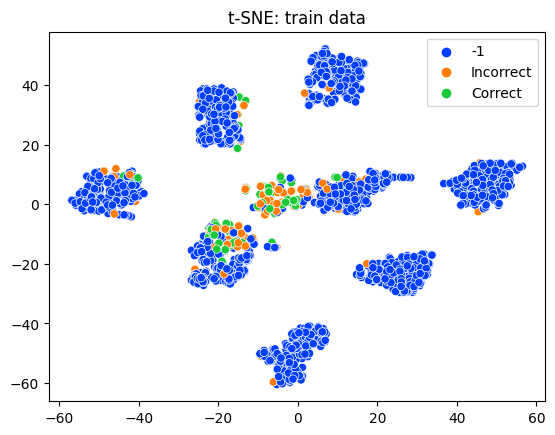

In [197]:

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    # options
    parser.add_argument('--ss_pipeline',
                        default = 1,
                        type = int,
                        help = "choose the ss model of which you want to test the accuracy") #0: org, 1: new_ss(k=5), 2: new_ss(k=10), 3: new_ss(k=20)
    parser.add_argument('--visualize',
                        default = True,
                        action = "store_true",
                        help = "visualize the test accuracy by topic")
    args = parser.parse_args(args = [])
    args.pd_labels_path = '/home/yewon/factcheck_automization'
    if args.ss_pipeline in [0, 1, 2]:
      args.model = torch.load('/home/yewon/factcheck_automization/new_ss/tuned_model.pt')
      print('===== Model patched =====')
    args.device = "cuda" if torch.cuda.is_available() else "cpu"
    bertmodel, vocab = get_pytorch_kobert_model()
    tokenizer_bert = get_tokenizer()
    args.tok = nlp.data.BERTSPTokenizer(tokenizer_bert, vocab, lower = False)
    args.max_len = 64
    if args.visualize == True:
        args.tsne_train_data_dir = '/home/yewon/factcheck_automization/naver_news_dict.pickle'


# max_len = 64
# batch_size = 32
# warmup_ratio = 0.1
# num_epochs = 10
# max_grad_norm = 1
# log_interval = 200
# learning_rate = 5e-5

    dataset_claim = getdataset_claim(args)
    dataset_news = getdataset_news(args)

    print("===== Datasets ready =====")
    
    if args.visualize:
        visualize(args, dataset_claim, dataset_news)



In [54]:
tsne_model_for_claim = TSNE(2)
results_test_data = tsne_model_for_claim.fit_transform(dataset['emb'])


In [151]:
type(dataset_claim['emb'])

tuple

In [139]:
len(dataset_news['data'][0])

1600

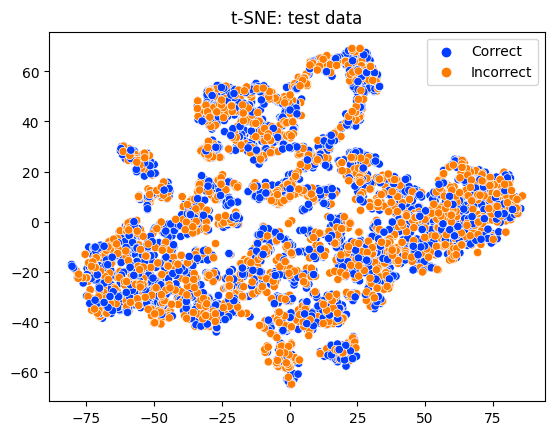

In [55]:
palette = sns.color_palette('bright', 8)

sns.scatterplot(x = results_test_data[:, 0], y = results_test_data[:, 1], hue = dataset['is_correct'], palette = palette)
plt.title('t-SNE: test data')
plt.show()

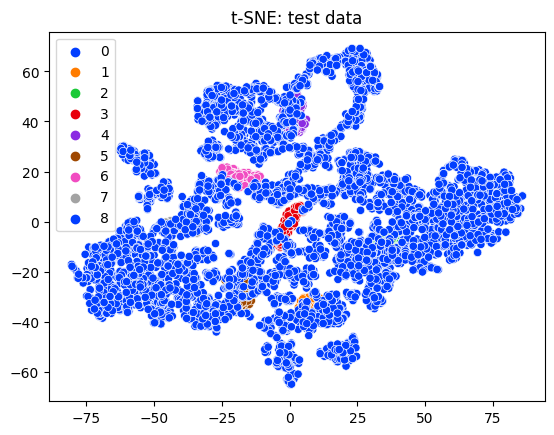

In [83]:
naver_news_dict['target']
merged_list = [i for i in naver_news_dict['target']]
merged_list.extend([8]*len(results_test_data))
palette = sns.color_palette('bright', 8)

sample = np.concatenate((results_train_data, results_test_data), axis = 0)
sns.scatterplot(x = sample[:, 0], y = sample[:, 1], hue = merged_list, palette = palette)
plt.title('t-SNE: test data')
plt.show()